In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import os
from tqdm import tqdm
import matplotlib.pyplot as plt


class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(1, 320)  
        self.out = nn.Linear(320, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [52]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = torch.sum(torch.abs(inl.weight.data[i])).item()
        outg = torch.sum(torch.abs(oul.weight.data[:,i])).item()

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    diff = (torch.sum(torch.abs(inl.weight.data - ninc)).item(), torch.sum(torch.abs(oul.weight.data-noul)).item())

    inl.weight.data = ninc
    oul.weight.data = noul

    return diff



In [53]:
def neuralBalance(inl, oul, order=1):
    prev = torch.linalg.norm(inl.weight, dim=1, ord=order)
    out = torch.linalg.norm(oul.weight, dim = 0, ord=order)

    opt = torch.sqrt(out/prev)

    inl.weight.data = inl.weight*opt.unsqueeze(1)
    oul.weight.data = oul.weight/opt

In [54]:
X = torch.linspace(0, 4 * np.pi, 50).unsqueeze(-1)  
Y = torch.sin(X)  
X = X.to('cuda')
Y = Y.to('cuda')
l1_lambda = 0.0005

model = model.to('cuda')
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad() 
    outputs = model(X)  
    loss = criterion(outputs, Y) 

    # l1_penalty = sum(p.abs().sum() for p in model.parameters())
    # loss += l1_lambda * l1_penalty

    loss.backward() 
    optimizer.step() 
    
    if epoch%50 == 0:
        for i in range(len(lay)):
            if i > 0 and i <= len(lay)-1:
                di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])
                while(di[0]+di[1] > .001):
                    di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')


Linear
Linear
Epoch 0/10000, Loss: 15.12900447845459
Epoch 50/10000, Loss: 0.30009692907333374
Epoch 100/10000, Loss: 0.20572711527347565
Epoch 150/10000, Loss: 0.17526572942733765
Epoch 200/10000, Loss: 0.15204183757305145
Epoch 250/10000, Loss: 0.1336437165737152
Epoch 300/10000, Loss: 0.11722707748413086
Epoch 350/10000, Loss: 0.10224400460720062
Epoch 400/10000, Loss: 0.09368440508842468
Epoch 450/10000, Loss: 0.08505545556545258
Epoch 500/10000, Loss: 0.08056049793958664
Epoch 550/10000, Loss: 0.07597549259662628
Epoch 600/10000, Loss: 0.07533484697341919
Epoch 650/10000, Loss: 0.07056839019060135
Epoch 700/10000, Loss: 0.06862466037273407
Epoch 750/10000, Loss: 0.0659991130232811
Epoch 800/10000, Loss: 0.06517547369003296
Epoch 850/10000, Loss: 0.06353063881397247
Epoch 900/10000, Loss: 0.060770731419324875
Epoch 950/10000, Loss: 0.06003383919596672
Epoch 1000/10000, Loss: 0.05917368829250336
Epoch 1050/10000, Loss: 0.05703416094183922
Epoch 1100/10000, Loss: 0.054617565125226974

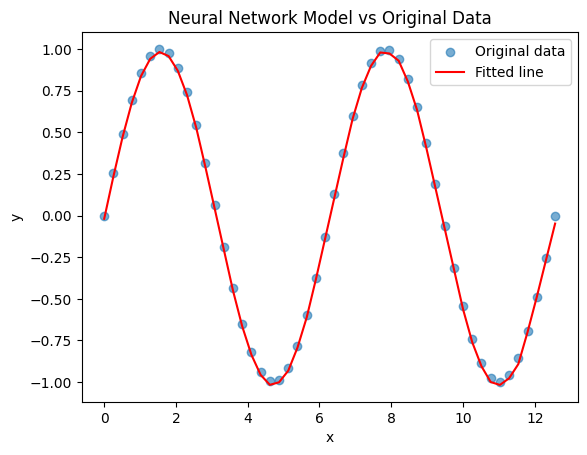

In [55]:
with torch.no_grad():
    predicted = model(X).cpu().detach().data.numpy()

X = X.cpu().detach().data.numpy()
Y = Y.cpu().detach().data.numpy()

plt.scatter(X, Y, label='Original data', alpha=0.6)
plt.plot(X, predicted, label='Fitted line', color='red')
plt.legend()
plt.title('Neural Network Model vs Original Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

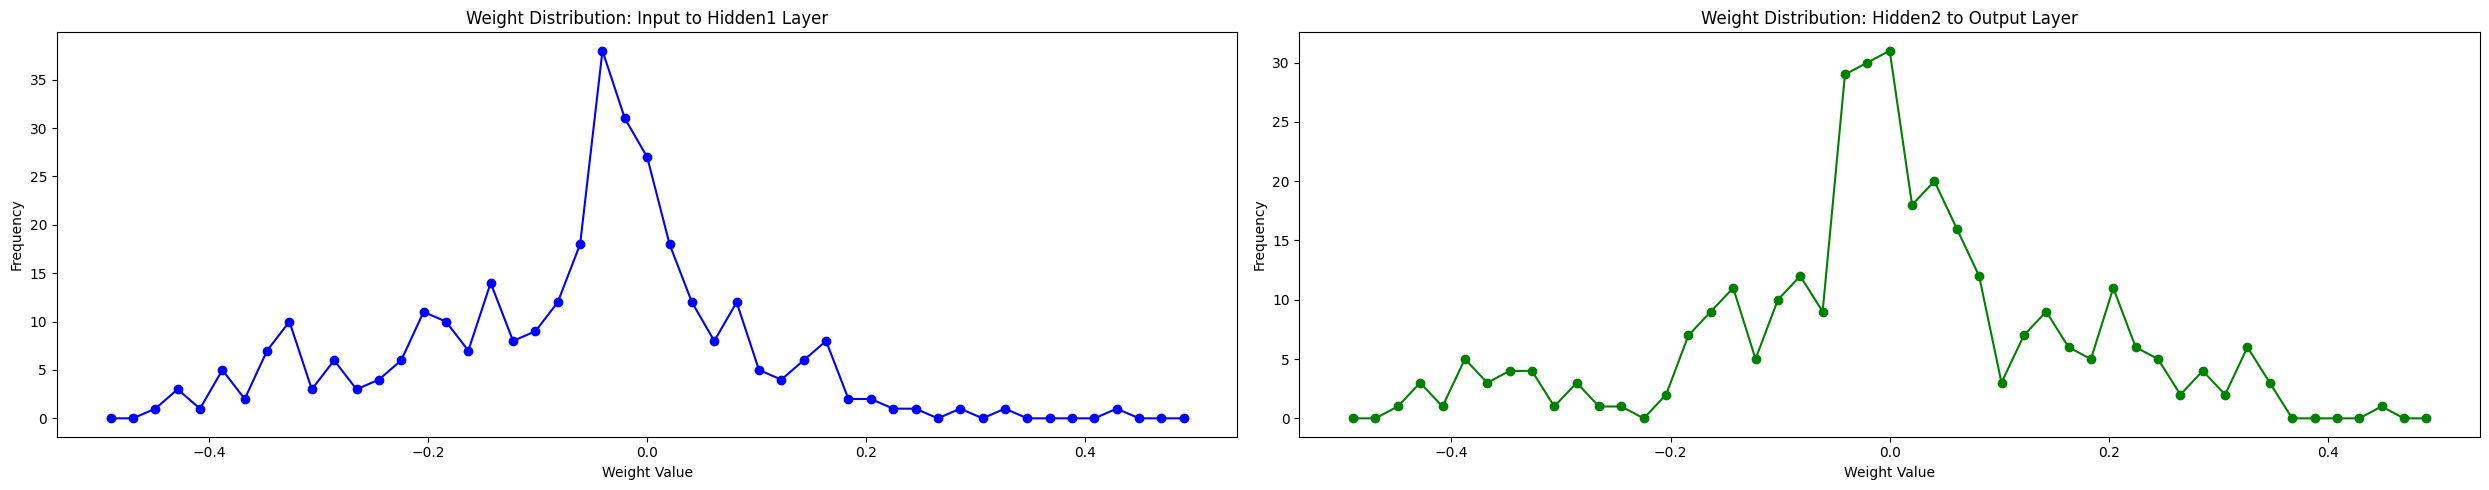

In [56]:
fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 2, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [57]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 293
Number of non-zero weights greater than 0.01 in layer 3: 289
